# Upwellling characteristics

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d
import scipy.stats as ss
from collections import OrderedDict
from matplotlib import gridspec

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# for ood
import sys  
sys.path.insert(0, '/g/data/x77/cy8964/Honours/spatial_correspodence/')

from correlation import Compute_Correlation
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35427/status,
Dashboard: /proxy/35427/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39045,Workers: 4
Dashboard: /proxy/35427/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:40937,Total threads: 2
Dashboard: /proxy/38965/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:33649,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

### Load important parameters

In [4]:
expt = '01deg_jra55v13_ryf9091'
# reference density value:
rho_0 = 1035.0
g = 9.81

In [5]:
## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)


In [6]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 2.45 s, sys: 961 ms, total: 3.42 s
Wall time: 18.6 s


In [7]:
path = '/g/data/x77/cy8964/Post_Process/New_SO/Paper_Data/'

In [8]:
def find_lower_upper_indices(hotspot, j_contour):
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
        prefix = 400
    else:
        suffix = ''
        prefix = 0
    lat_along_contour = xr.open_dataset(path+'Contour_coordinates/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    lon_along_contour = xr.open_dataset(path+'Contour_coordinates/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour
    
    if hotspot =='MR' and j_contour == 'A' or 'B' or 'J' or 'L' or 'N':
        lon_along_contour[1]=-279.95
    for i in np.arange(prefix,len(lon_along_contour)):
        if lon_along_contour[i]>hotspot_dict[hotspot]['lower_lon']:
            lower_index = i
            break
    for i in np.arange(prefix,len(lon_along_contour)):
        if lon_along_contour[i]<hotspot_dict[hotspot]['upper_lon']:
            upper_index = i
        elif lon_along_contour[i]>hotspot_dict[hotspot]['upper_lon']:
            break

    return lower_index, upper_index



In [9]:
def distance_save(j_contour):
    lat_range = contour_dict[j_contour]['lat_range']
    SSH = contour_dict[j_contour]['SSH']
    dxu = cc.querying.getvar(expt,'dxu',session,ncfile = 'ocean_grid.nc',n=1)
    dxu = dxu.sel(yu_ocean = lat_range)
    dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
    dyt = dyt.sel(yt_ocean = lat_range)
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    lat_along_contour = xr.open_dataset(path+'Contour_coordinates/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour
    num_points = len(lat_along_contour)
    lat_t = cc.querying.getvar(expt,'geolat_t',session,ncfile = 'ocean_grid.nc',n=1)
    lat_t = lat_t.sel(yt_ocean = lat_range)
    lon_t = cc.querying.getvar(expt,'geolon_t',session,ncfile = 'ocean_grid.nc',n=1)
    lon_t = lon_t.sel(yt_ocean = lat_range)
    
    outfile = path+'Contour_coordinates/SO_slope_contour_'+str(SSH)+'m_SSH.npz'
    data = np.load(outfile)

        # if there is a bend in the contour, add the distance using length of diagonal, not sum of
    # 2 edges, to be more representative.
    mask_y_transport_numbered = data['mask_y_transport_numbered']
    mask_x_transport_numbered = data['mask_x_transport_numbered']
    contour_masked_above = data['contour_masked_above']

    distance_along_contour = np.zeros((num_points))
    x_indices = np.sort(mask_x_transport_numbered[mask_x_transport_numbered>0])
    y_indices = np.sort(mask_y_transport_numbered[mask_y_transport_numbered>0])
    skip = False
    for count in range(1,num_points):
        if skip == True:
            skip = False
            continue
        if count in y_indices:
            if count + 1 in y_indices:
                # note dxu and dyt do no vary in x:
                jj = np.where(mask_y_transport_numbered==count)[0]
                distance_along_contour[count-1] = (dxu[jj,990])[0]
            else:
                jj0 = np.where(mask_y_transport_numbered==count)[0]
                jj1 = np.where(mask_x_transport_numbered==count+1)[0]
                diagonal_distance = 0.5*np.sqrt((dxu[jj0,990])[0]**2+\
                    (dyt[jj1,990])[0]**2)
                distance_along_contour[count-1] = diagonal_distance
                distance_along_contour[count] = diagonal_distance
                # skip to next count:
                skip = True
        # count in x_indices:
        else:
            if count + 1 in x_indices:
                jj = np.where(mask_x_transport_numbered==count)[0]
                distance_along_contour[count-1] = (dyt[jj,990])[0]
            else:
                jj0 = np.where(mask_x_transport_numbered==count)[0]
                jj1 = np.where(mask_y_transport_numbered==count+1)[0]
                diagonal_distance = 0.5*np.sqrt((dyt[jj0,990])[0]**2+\
                    (dxu[jj1,990])[0]**2)
                distance_along_contour[count-1] = diagonal_distance
                distance_along_contour[count] = diagonal_distance
                # skip to next count:
                skip = True
    # fix last value:
    if distance_along_contour[-1] == 0:
        count = count + 1
        if count in y_indices:
            jj = np.where(mask_y_transport_numbered==count)[0]
            distance_along_contour[-1] = (dxu[jj,990])[0]
        else:
            jj = np.where(mask_x_transport_numbered==count)[0]
            distance_along_contour[-1] = (dyt[jj,990])[0]

    # units are 10^3 km:
    distance_along_contour = np.cumsum(distance_along_contour)/1e3/1e3        
    return distance_along_contour

In [10]:
def distance(hotspot,j_contour):
    distance_along_contour = xr.open_dataset(path+'distance_along_contour/SO_'+j_contour+'_distance_along_contour.nc').distance
    if hotspot == 'KP':
        lower_index1, upper_index1 = find_lower_upper_indices('KP1', j_contour)
        lower_index2, upper_index2 = find_lower_upper_indices('KP2', j_contour)
        dist80 = distance_along_contour[upper_index1]-distance_along_contour[lower_index1]
        distance_along_contour = np.append(distance_along_contour[lower_index1:upper_index1]-distance_along_contour[lower_index1],
                                           distance_along_contour[lower_index2:upper_index2]+dist80)
    else:
        lower_index, upper_index = find_lower_upper_indices(hotspot, j_contour)
        distance_along_contour = distance_along_contour[lower_index:upper_index]-distance_along_contour[lower_index]
        
    return distance_along_contour

In [11]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

In [12]:
sum_T_array=xr.open_dataset(path+'Upwelling_distribution/sum_TD_over_hotspots_notoverlapping.nc').sum_T_array
depth_array=xr.open_dataset(path+'Upwelling_distribution/mean_h_over_hotspots_notoverlapping_nozerov2.nc').mean_h_array_masked


In [13]:
sum_T_array_tot=xr.open_dataset(path+'Upwelling_distribution/sum_TD_total.nc').sum_T_array.sel(hotspot = 'total')

In [15]:

top_rho = xr.open_dataset(path+'Upwelling_distribution/rho_and_h_on_contours.nc').top_rho
bottom_rho = xr.open_dataset(path+'Upwelling_distribution/rho_and_h_on_contours.nc').bottom_rho
h = xr.open_dataset(path+'Upwelling_distribution/rho_and_h_on_contours.nc').h


In [16]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 13.5})

MR -0.15000000000000002
PAR -0.15000000000000002
DP -0.1
SWIR -0.30000000000000004
KP -0.1


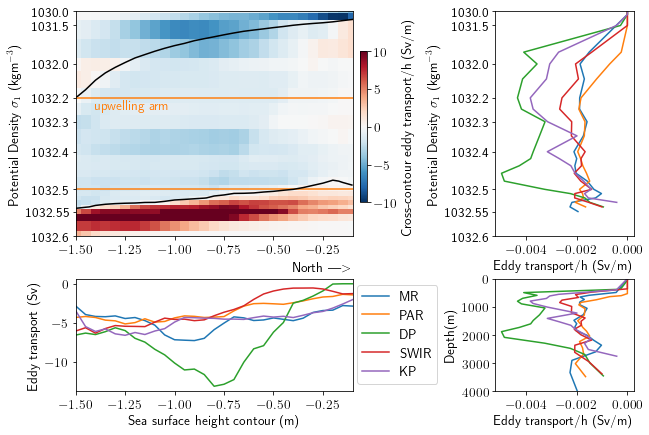

In [17]:
gs = gridspec.GridSpec(2,3,width_ratios=[2, 0.1,1], height_ratios = [2,1]) 
fig = plt.figure(figsize = (10,7))
ax0, ax1, ax2, ax3 = plt.subplot(gs[0,0]), plt.subplot(gs[1,0]), plt.subplot(gs[0,2]), plt.subplot(gs[1,2])
gs.update(wspace = 0.45, hspace = 0.25)

scfac = 20
p1 = ax0.pcolormesh(sum_T_array_tot.SSH, (sum_T_array_tot.sel(isopycnal_bins = slice(1024,1033)).isopycnal_bins.values-1024)**scfac,
                    (-sum_T_array_tot/1e6).sel(isopycnal_bins = slice(1024,1033)), cmap = 'RdBu_r', vmin = -10,vmax = 10)
rhos = np.array([1030,1031.5,1032,1032.2,1032.3, 1032.4,1032.5,1032.55,1032.6])
ax0.plot(sum_T_array.SSH, (top_rho.sel(hotspot = 'total').isel(isopycnal_bins = 0)-1024)**scfac, color = 'k', linestyle = '-', label = 'max. top density')
#ax0.plot(sum_T_array.SSH, (bottom_rho.sel(hotspot = 'total').isel(isopycnal_bins = 0)-1024)**scfac,  color = 'k', linestyle = 'dotted', label = 'min. bottom density')
#ax0.plot(sum_T_array.SSH, bottom_rho.sel(hotspot = 'total').isel(isopycnal_bins = 0)-1024,  color = 'k', linestyle = '-', label = 'direction cut-off')
ax0.hlines(8.2**scfac,-1.5,-0.1,  color = 'C1', linestyle = '-')
ax0.hlines(8.5**scfac,-1.5,-0.1,  color = 'C1', linestyle = '-')
ax0.text(-1.4,8.25**scfac,'upwelling arm', color = 'C1')
ax0.set_yticks((rhos-1024)**scfac)
ax0.set_yticklabels(rhos)
ax0.set_ylim(8.6**scfac,5**scfac)
ax_cb = plt.axes([0.52, 0.5, 0.01, 0.3])
fig.colorbar(p1, cax = ax_cb, label = 'Cross-contour eddy transport/h (Sv/m)')
ax0.set_ylabel('Potential Density $\sigma_1$ (kgm$^{-3}$)')
mask = sum_T_array_tot.sel(isopycnal_bins = slice(1032.4,1032.57))
ax0.contour(mask.SSH, (mask.isopycnal_bins.values-1024)**scfac, mask, levels = [0.5], colors = 'k', linewidths = 1.5, label = 'bottom water')
#ax0.legend(loc = 'upper left', fontsize = 10)
for j in np.arange(5):
    hotspot = ['MR','PAR','DP','SWIR','KP'][j]
    color = ['C0','C1','C2','C3','C4'][j]
    top_rho_j = top_rho.sel(hotspot = hotspot)
    h_j = h.sel(hotspot = hotspot)
    density_array= (sum_T_array.sel(hotspot = hotspot)*0+sum_T_array.isopycnal_bins)
    density_mask = (density_array.where(density_array>top_rho_j)*0+1).fillna(0)
    ax2.plot((-sum_T_array/1e6*density_mask/h_j).where(sum_T_array>0).sel(isopycnal_bins = slice(1024,1032.55)).sel(hotspot = hotspot).mean('SSH'),
             (sum_T_array.sel(isopycnal_bins = slice(1024,1032.55)).isopycnal_bins.values-1024)**scfac,
             label = hotspot, color = color)
    if hotspot == 'KP':
        ax3.plot((-sum_T_array/1e6*density_mask/h_j).where(sum_T_array>0).sel(isopycnal_bins = slice(1024,1032.55)).sel(hotspot = hotspot).mean('SSH'),
                -depth_array.sel(isopycnal_bins = slice(1024,1032.55)).sel(hotspot = hotspot).mean('SSH'),
             label = hotspot,color = color)
    else:
        ax3.plot((-sum_T_array/1e6*density_mask/h_j).where(sum_T_array>0).sel(isopycnal_bins = slice(1024,1032.55)).sel(hotspot = hotspot).mean('SSH'),
                depth_array.sel(isopycnal_bins = slice(1024,1032.55)).sel(hotspot = hotspot).mean('SSH'),
             label = hotspot,color = color)    
    upwelling_arm = (-sum_T_array/1e6*density_mask).where(sum_T_array>0).sel(hotspot = hotspot)
    upwelling_arm.sum('isopycnal_bins').plot(color = color,label = hotspot, ax = ax1)
    print(hotspot+' '+str(upwelling_arm.SSH[upwelling_arm.sum('isopycnal_bins').argmax().values].values))
# top_rho_j = top_rho.sel(hotspot = 'total')
# bottom_rho_j = bottom_rho.sel(hotspot = 'total')
# h_j = h.sel(hotspot = 'total')
# density_array= (sum_T_array_tot*0+sum_T_array_tot.isopycnal_bins)
# density_mask = (density_array.where(density_array < bottom_rho_j).where(density_array>top_rho_j)*0+1).fillna(0)

# ax2.plot((sum_T_array_tot*density_mask/1e6/h_j).where(sum_T_array_tot>0).sel(isopycnal_bins = slice(1024,1032.55)).mean('SSH'),
#              (sum_T_array.sel(isopycnal_bins = slice(1024,1032.55)).isopycnal_bins.values-1024)**scfac,
#               color = 'k', label = 'Total')
# upwelling_arm = (sum_T_array_tot*density_mask/1e6).where(sum_T_array_tot>0).sel(isopycnal_bins = slice(1031.8,1032.6))
# upwelling_arm.sum('isopycnal_bins').plot(color = 'k',label = 'Total', ax = ax1)

ax1.legend(bbox_to_anchor=(1.33,1))
ax2.set_ylim(1032.6,1030)
ax2.set_yticks((rhos-1024)**scfac)
ax2.set_yticklabels(rhos)
ax2.set_ylim(8.6**scfac,5**scfac)
ax2.set_ylabel('Potential Density $\sigma_1$ (kgm$^{-3}$)')
ax2.set_xlabel('Eddy transport/h (Sv/m)')
ax1.set_ylabel('Eddy transport (Sv)')
ax1.set_title('')
ax1.set_xlabel('Sea surface height contour (m)')
ax1.text(-0.4,1.5, 'North ---$>$')
ax3.set_ylim(4000,0)
ax3.set_xlabel('Eddy transport/h (Sv/m)')
ax3.set_ylabel('Depth(m)')

ax0.set_xlim(-1.5,-0.1)
ax1.set_xlim(-1.5,-0.1)

fig.savefig('upwelling_details.png',dpi = 400)